In [26]:
import tensorflow as tf
import keras
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers.core import Dropout 
from keras.layers.core import Flatten
from keras.models import Sequential
from keras.models import model_from_json
from keras.callbacks import LearningRateScheduler 
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import np_utils
import glob         
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore") 
import mymodule
from mymodule import BatchGenerator
from mymodule import Make_Raw_List2
from mymodule import plot_loss_accuracy_graph
import shutil
import os

In [27]:
#Input File
csv_filename = "data.csv"

#Output File
best_model_path = 'best_model_path_an_R.h5'

In [31]:
#get the path
root=os.getcwd()
root

'/Users/ziyingye/Desktop/stats/stats402/data/Fundus_Diagnosis-master'

In [32]:
#load the training data
img_height=256
img_width=256
batch_size=16
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  root+'/img_an/train',
  validation_split=0.25,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10439 files belonging to 2 classes.
Using 7830 files for training.


In [33]:
#load the validation data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  root+'/img_an/train',
  validation_split=0.25,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10439 files belonging to 2 classes.
Using 2609 files for validation.


In [34]:
#load the test data
test_ds=tf.keras.preprocessing.image_dataset_from_directory(
  root+'/img_an/test',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False)

Found 2608 files belonging to 2 classes.


In [35]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model

In [36]:
#build the ResNet model
model = ResNet50(include_top=False, input_shape=(img_height, img_width, 3))
flat1 = Flatten()(model.output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(2, activation='softmax')(class1)
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [37]:
#train the model
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "sgd", metrics = ["accuracy"])
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
490/490 [==============================] - 9110s 19s/step - loss: 0.6062 - accuracy: 0.7659 - val_loss: 0.6181 - val_accuracy: 0.6926
Epoch 2/5
490/490 [==============================] - 9049s 18s/step - loss: 0.3568 - accuracy: 0.8341 - val_loss: 0.4869 - val_accuracy: 0.7919
Epoch 3/5
490/490 [==============================] - 8481s 17s/step - loss: 0.2545 - accuracy: 0.8889 - val_loss: 0.4479 - val_accuracy: 0.8237
Epoch 4/5
490/490 [==============================] - 6424s 13s/step - loss: 0.1829 - accuracy: 0.9213 - val_loss: 0.6065 - val_accuracy: 0.7961
Epoch 5/5
490/490 [==============================] - 6504s 13s/step - loss: 0.1399 - accuracy: 0.9448 - val_loss: 0.6551 - val_accuracy: 0.7808


In [38]:
#save the model
model.save(best_model_path)

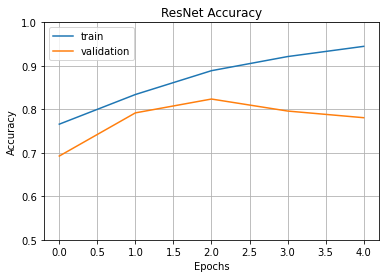

In [44]:
# plot the trend of training and validation accuracy
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.5,ymax=1)
plt.grid()
plt.title('ResNet Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show() 

In [40]:
#load the saved trained the model
test_model = keras.models.load_model(best_model_path)

In [41]:
#predict the test data
df_p=pd.DataFrame(test_model.predict(test_ds))
df_p

163/163 [==============================] - 524s 3s/step


,0,1
0,0.999988,1.171754e-05
1,0.999991,8.962489e-06
2,0.641074,3.589263e-01
3,1.000000,8.199358e-14
4,0.579556,4.204441e-01
...,...,...
2603,0.040502,9.594985e-01
2604,0.762384,2.376161e-01
2605,0.585283,4.147172e-01
2606,0.802209,1.977910e-01


In [42]:
#add the original label as the last column in the dataframe
test_label = np.concatenate([y for x, y in test_ds], axis=0) 
df_l=pd.DataFrame(test_label)
df_l
pd.concat([df_p,df_l],axis=1)

,0,1,0
0,0.999988,1.171754e-05,0
1,0.999991,8.962489e-06,0
2,0.641074,3.589263e-01,0
3,1.000000,8.199358e-14,0
4,0.579556,4.204441e-01,0
...,...,...,...
2603,0.040502,9.594985e-01,1
2604,0.762384,2.376161e-01,1
2605,0.585283,4.147172e-01,1
2606,0.802209,1.977910e-01,1


In [43]:
#evaluate the model
model.evaluate(test_ds)

163/163 [==============================] - 436s 3s/step - loss: 0.6622 - accuracy: 0.7742


[0.6621618270874023, 0.7741564512252808]